In [1]:
from HFM.common import db
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db_conn = db.DB(db.DSN.HFMNAVBI_BIDataWarehouse)

In [3]:
sel_sql = """
SELECT FPSA.Time_ID AS DateValue, DP.Item AS Item, FPSA.Store_ID , SUM(FPSA.QuantityInSalesUOM) AS SalesQuantity , 
CASE WHEN SUM(FPSA.Quantity) = 0.0 THEN SUM(FPSA.ExtendedNetAmount) ELSE SUM(FPSA.ExtendedNetAmount) / SUM(FPSA.Quantity) END AS UnitRRP
FROM dbo.Fact_POS_Sales_Agg_Daily FPSA WITH (NOLOCK)
INNER JOIN dbo.Dim_PLUItem DP WITH (NOLOCK) ON DP.PLUItem_ID = FPSA.PLUItem_ID
WHERE FPSA.Time_ID >= 20160101
AND FPSA.Store_ID = 10
AND DP.Item IN ('10681')
AND FPSA.Quantity <> 0.00
AND FPSA.ExtendedNetAmount > 0.00
AND FPSA.Time_ID < dbo.fn_ConvertDateToInt(GETDATE())
GROUP BY FPSA.Time_ID, DP.Item , FPSA.Store_ID
ORDER BY DP.Item , FPSA.Time_ID;
"""

data_df = db_conn.get_pandas_df_from_sql(sel_sql)
data_df['DateValue'] = pd.to_datetime( data_df['DateValue'], format='%Y%m%d')
data_df['Item'] = data_df['Item'].astype(str)
data_df = pd.concat( [data_df, pd.get_dummies(data_df['Item'],prefix='Item')], axis=1)

data_df['MonthNo'] = data_df['DateValue'].dt.month
data_df['YearNo'] = data_df['DateValue'].dt.year
data_df['DayOfMonth'] = data_df['DateValue'].dt.day # Day of Month
data_df['DayOfYear'] = data_df['DateValue'].dt.strftime('%j').astype(int) #Day of year
data_df['WeekOfYear'] = data_df['DateValue'].dt.strftime('%W').astype(int) #Week of year
data_df['DayOfWeek'] = data_df['DateValue'].dt.strftime('%w').astype(int) # Weekday No
data_df['IsWeekend'] = data_df['DayOfWeek'].apply(lambda x: 1 if x in [0,6] else 0)


data_df.head(10)

,DateValue,Item,Store_ID,SalesQuantity,UnitRRP,Item_10681,MonthNo,YearNo,DayOfMonth,DayOfYear,WeekOfYear,DayOfWeek,IsWeekend
0,2016-01-03,10681,10,1.0,9.29,1,1,2016,3,3,0,0,1
1,2016-01-06,10681,10,2.0,9.29,1,1,2016,6,6,1,3,0
2,2016-01-13,10681,10,1.0,9.29,1,1,2016,13,13,2,3,0
3,2016-01-14,10681,10,1.0,9.29,1,1,2016,14,14,2,4,0
4,2016-01-15,10681,10,1.0,9.29,1,1,2016,15,15,2,5,0
5,2016-02-01,10681,10,1.0,9.29,1,2,2016,1,32,5,1,0
6,2016-02-15,10681,10,1.0,9.29,1,2,2016,15,46,7,1,0
7,2016-02-18,10681,10,1.0,9.29,1,2,2016,18,49,7,4,0
8,2016-02-22,10681,10,2.0,9.29,1,2,2016,22,53,8,1,0
9,2016-02-24,10681,10,1.0,9.29,1,2,2016,24,55,8,3,0


In [4]:
train_df = data_df[data_df['DateValue'] < '2020-08-01']
test_df = data_df[data_df['DateValue'] >= '2020-08-01']
print(train_df.shape)
print(test_df.shape)

(400, 13)
(45, 13)


In [5]:
display(train_df.head(5))
display(test_df.head(5))

,DateValue,Item,Store_ID,SalesQuantity,UnitRRP,Item_10681,MonthNo,YearNo,DayOfMonth,DayOfYear,WeekOfYear,DayOfWeek,IsWeekend
0,2016-01-03,10681,10,1.0,9.29,1,1,2016,3,3,0,0,1
1,2016-01-06,10681,10,2.0,9.29,1,1,2016,6,6,1,3,0
2,2016-01-13,10681,10,1.0,9.29,1,1,2016,13,13,2,3,0
3,2016-01-14,10681,10,1.0,9.29,1,1,2016,14,14,2,4,0
4,2016-01-15,10681,10,1.0,9.29,1,1,2016,15,15,2,5,0


,DateValue,Item,Store_ID,SalesQuantity,UnitRRP,Item_10681,MonthNo,YearNo,DayOfMonth,DayOfYear,WeekOfYear,DayOfWeek,IsWeekend
400,2020-08-05,10681,10,1.0,9.490,1,8,2020,5,218,31,3,0
401,2020-08-08,10681,10,1.0,9.490,1,8,2020,8,221,31,6,1
402,2020-08-10,10681,10,2.0,8.305,1,8,2020,10,223,32,1,0
403,2020-08-16,10681,10,1.0,9.490,1,8,2020,16,229,32,0,1
404,2020-08-17,10681,10,1.0,9.490,1,8,2020,17,230,33,1,0


In [6]:
import xgboost as xgb

/opt/tljh/user/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
#'31004', '25201','40701','40601'
cols = ['Item_10681', 'MonthNo','YearNo','DayOfMonth',
        'DayOfYear','WeekOfYear','DayOfWeek','IsWeekend']

train_mat = xgb.DMatrix(data=train_df[cols],
                       label=train_df['SalesQuantity'])
test_mat = xgb.DMatrix(data=test_df[cols],
                      label=test_df['SalesQuantity'])

In [8]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [9]:
model.fit(train_df[cols],train_df['SalesQuantity'])
#,eval_set=[(test_df[cols],test_df['SalesQuantity'])],
#early_stopping_rounds = 10,eval_metric='mae',verbose=False

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method=None, validate_parameters=False,
             verbosity=None)

In [10]:
predict_df = model.predict(test_df[cols])

In [11]:
predict_df

array([1.156342 , 1.278098 , 1.0173459, 1.2595196, 1.30639  , 1.3805673,
       1.2899241, 1.2720313, 1.142518 , 1.3505126, 1.9791288, 1.6592495,
       1.5719705, 1.7910016, 0.782672 , 0.8868084, 0.9339458, 1.2324493,
       0.8832097, 0.958361 , 1.2372001, 1.2390065, 1.2517536, 1.3291295,
       1.4820949, 1.3615907, 1.7667342, 0.9449247, 1.088822 , 1.3325002,
       1.2784188, 1.4607604, 1.4029925, 1.3366233, 1.370505 , 1.1008351,
       1.0846274, 1.0575464, 1.0355146, 1.0842109, 1.1548916, 2.0136375,
       1.3386413, 1.2105976, 1.0355973], dtype=float32)

In [12]:
result_df = test_df[['Item','SalesQuantity']]
result_df.reset_index(inplace=True,drop = True)
result_df['Predicted'] = pd.DataFrame(predict_df, columns=['Predicted'])
result_df

/home/jupyter-apandey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Item,SalesQuantity,Predicted
0,10681,1.0,1.156342
1,10681,1.0,1.278098
2,10681,2.0,1.017346
3,10681,1.0,1.259520
4,10681,1.0,1.306390
5,10681,1.0,1.380567
6,10681,1.0,1.289924
7,10681,2.0,1.272031
8,10681,2.0,1.142518
9,10681,1.0,1.350513


,Item,SalesQuantity,Predicted
0,10681,1.0,1.156342
1,10681,1.0,1.278098
2,10681,2.0,1.017346
3,10681,1.0,1.259520
4,10681,1.0,1.306390
5,10681,1.0,1.380567
6,10681,1.0,1.289924
7,10681,2.0,1.272031
8,10681,2.0,1.142518
9,10681,1.0,1.350513


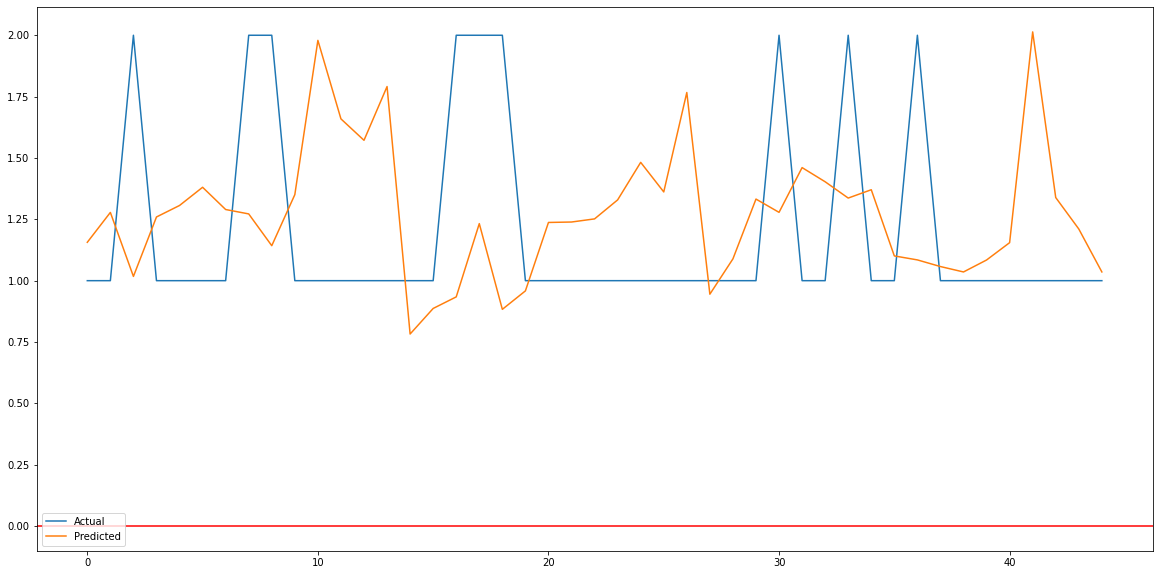

In [15]:
plot_data = result_df[result_df.Item == '10681']
plt.figure(figsize=(20,10))
plt.plot(plot_data['SalesQuantity'] , label='Actual')
plt.plot(plot_data['Predicted'] , label='Predicted')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend(loc='lower left')
display(plot_data.head(10))
plt.show()